## Activation map and heatmap example with CIFAR-10.
You can find more about CIFAR-10 at https://www.cs.toronto.edu/~kriz/cifar.html.

This example is part of the [K-CAI Neural API](https://github.com/joaopauloschuler/k-neural-api).

In [1]:
#@title Global Settings
from tensorflow import keras
import tensorflow.keras.layers
import tensorflow.keras.models
import tensorflow.keras.datasets
from tensorflow.keras import regularizers
dataset=tensorflow.keras.datasets.cifar10 
batch_size=64 # @param [32, 64, 128, 256, 512] {type:"raw"} 
epochs=32 # @param [32, 64, 128, 256, 512] {type:"raw"}
l2_decay = 0.000001 #@param {type:"number"}
initial_learning_rate = 0.01 #@param {type:"number"}
verbose=True #@param {type:"boolean"}
bipolar_input=True #@param {type:"boolean"}
input_shape = (32, 32, 3)

In [ ]:
import os
if not os.path.isdir('k'):
  !git clone https://github.com/joaopauloschuler/k-neural-api.git k
else:
  !cd k && git pull
!cd k && pip install .

# Build the Model/Neural Network

In [3]:
import cai.densenet
import cai.util

save_dir = os.path.join(os.getcwd(), 'saved_models')
cai.util.create_folder_if_required(save_dir)
base_model_name = os.path.join(save_dir, 'activationandheatmapexample')

model = keras.models.Sequential()
model.add(keras.layers.Conv2D(64, (5, 5), padding='same',
                 input_shape=input_shape, kernel_regularizer=regularizers.l2(l2_decay)) )
model.add(keras.layers.Activation('relu'))
model.add(keras.layers.MaxPooling2D(pool_size=(2, 2)))
model.add(keras.layers.Conv2D(64, (1, 1), padding='same', kernel_regularizer=regularizers.l2(l2_decay)) )
model.add(keras.layers.Conv2D(64, (3, 3), padding='same', kernel_regularizer=regularizers.l2(l2_decay)) )
model.add(keras.layers.Activation('relu'))
model.add(keras.layers.Conv2D(64, (3, 3), padding='same', kernel_regularizer=regularizers.l2(l2_decay)) )
model.add(keras.layers.Activation('relu'))
model.add(keras.layers.Conv2D(256, (1, 1), padding='same', name='last_conv_layer', kernel_regularizer=regularizers.l2(l2_decay)) )
model.add(keras.layers.GlobalAveragePooling2D(name='avg_pool'))
#model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(10, kernel_regularizer=regularizers.l2(l2_decay)) )
model.add(keras.layers.Activation('softmax'))

if (verbose):
    model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 64)        4864      
_________________________________________________________________
activation (Activation)      (None, 32, 32, 64)        0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 16, 16, 64)        4160      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 16, 64)        36928     
_________________________________________________________________
activation_1 (Activation)    (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 16, 16, 64)        3

#Train the Model

In [ ]:
# Learning rate schedule.
def lrscheduler(epoch):
  return initial_learning_rate * (0.99**epoch)

fit_result,  model_name,  csv_name = cai.datasets.train_model_on_dataset(model, dataset, base_model_name, 
  plrscheduler=lrscheduler, batch_size=batch_size, epochs=epochs, lab=False, verbose=verbose, bipolar=bipolar_input, monitor='val_acc')

In [ ]:
x_train, y_train, x_test, y_test = cai.datasets.load_dataset(dataset, verbose=verbose, lab=False, bipolar=bipolar_input, base_model_name=base_model_name)
print('y_test shape:', y_test.shape)

# Show Activation Maps

image 4 has class 1


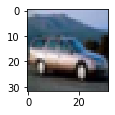

activation_maps min: 0.0  activation_maps max: 1.0


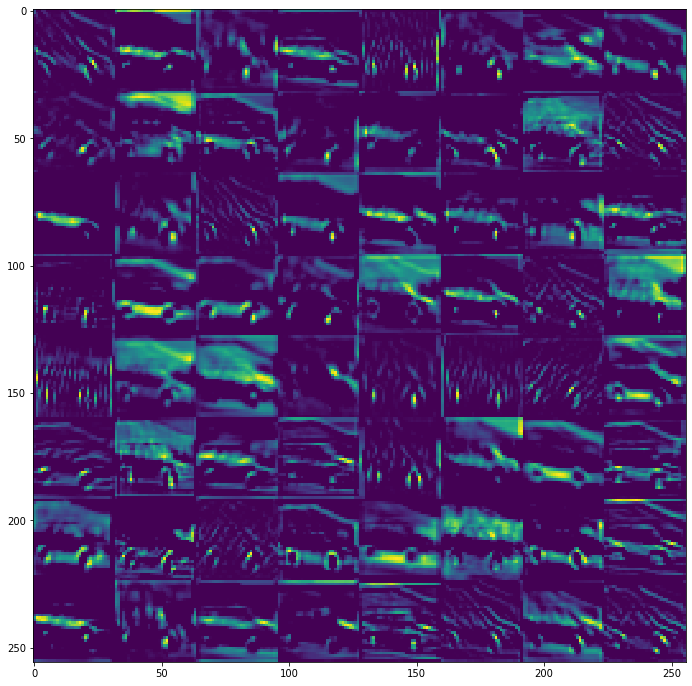

In [7]:
import cai.models
import numpy as np
import cv2
import matplotlib.pyplot as plt

image_position = 4 # the car
image_class = np.argmax(y_train[image_position])
print('image', image_position, 'has class', image_class)
localImageArray = []
localImageArray.append(x_train[image_position])
localImageArray = np.array(localImageArray, dtype='float32')
plt.figure(figsize = (1.5, 1.5))
plt.imshow((localImageArray[0]+2)/4, interpolation='nearest', aspect='equal')
plt.show()

conv_output = cai.models.PartialModelPredict(localImageArray, model, 'activation', False)

activation_maps = cai.util.slice_3d_into_2d(aImage=conv_output[0], NumRows=8, NumCols=8, ForceCellMax=True);
print('activation_maps min:', np.min(activation_maps), ' activation_maps max:', np.max(activation_maps))

plt.figure(figsize = (12, 12))
plt.imshow(activation_maps, interpolation='nearest', aspect='equal')
plt.show()

# Create the Heatmap

heat_map min: 0.0  heat_map max: 1.0
original image:


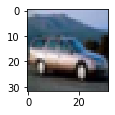

heatmap:


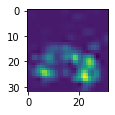

original image + heatmap:


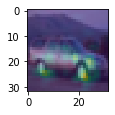

In [13]:
heat_map = cai.models.calculate_heat_map_from_dense_and_avgpool(aInput=localImageArray[0], target_class=image_class, pModel=model, pOutputLayerName='last_conv_layer', pDenseLayerName='dense')
heat_map_res = cv2.resize(heat_map, dsize=(localImageArray[0].shape[0], localImageArray[0].shape[1]), interpolation=cv2.INTER_CUBIC)

print('heat_map min:', np.min(heat_map), ' heat_map max:', np.max(heat_map))
print('original image:')
plt.figure(figsize = (1.5, 1.5))
plt.imshow((localImageArray[0]+2)/4, interpolation='nearest', aspect='equal')
plt.show()
print('heatmap:')
plt.figure(figsize = (1.5, 1.5))
plt.imshow(heat_map_res, interpolation='nearest', aspect='equal', alpha=1)
plt.show()
print('original image + heatmap:')
plt.figure(figsize = (1.5, 1.5))
plt.imshow(heat_map_res, interpolation='nearest', aspect='equal', alpha=1)
plt.imshow((localImageArray[0]+2)/4, interpolation='nearest', aspect='equal', alpha=0.5)
plt.show()

As you can see in the image above, the neural network is focusing (heat) on car wheels.

# Displaying First Layer Neuronal Patterns

neuron_patterns min: 0.0  neuron_patterns max: 1.0


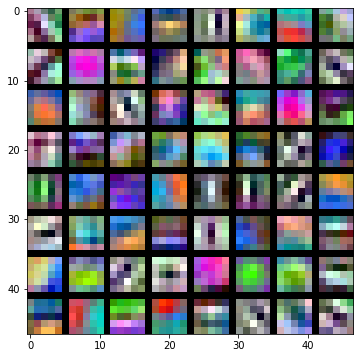

In [12]:
weights = model.get_layer('conv2d').get_weights()[0]
neuron_patterns = cai.util.show_neuronal_patterns(weights, NumRows = 8, NumCols = 8, ForceCellMax = True)
print('neuron_patterns min:', np.min(neuron_patterns), ' neuron_patterns max:', np.max(neuron_patterns))
plt.figure(figsize = (6, 6))
plt.imshow(neuron_patterns, interpolation='nearest', aspect='equal')
plt.show()